<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/bayesian-networks/bayesian_networks_pyagrum_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graphical Models

In [0]:
!pip install -q pyagrum

     |████████████████████████████████| 4.5MB 5.2MB/s 


In [0]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import Image

A **Bayesian network(BN)** is composed of random variables(nodes) and their conditional dependencies(arcs) which, together, form a directed acyclic graph (DAG). A conditional probability table (CPT) is associated with each node. It contains the conditional probability distribution of the node given its parents in the DAG:

Such a BN allows to manipulate the joint probability $\small P(C,S,R,W)$ using this decomposition:

$$\small P(C,S,R,W)=\prod_X P(X | Parents_X) = P(C) \cdot P(S | C) \cdot P(R | C) \cdot P(W | S,R)$$

Imagine you want to create your first Bayesian network, say for example the 'Water Sprinkler' network. This is an easy example. All the nodes are Boolean (only 2 possible values). You can proceed as follows.

In [0]:
Image(url='http://www-desir.lip6.fr/~phw/aGrUM/docs/last/notebooks/images/waterprinkler.png', width=500)

## Create the network topology

In [0]:
bn = gum.BayesNet('WatherSprinkler')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}


## Create the variables

pyAgrum provides 3 types of variables:
- LabelizedVariable
- RangeVariable
- DiscretizedVariable

We will use LabelizedVariable, which is a variable whose domain is a finite set of labels. 

The next cell will create a variable named 'c', with 2 values and described as 'cloudy?', and it will add it to the BN. The value returned is the id of the node in the graphical structure (the DAG). pyAgrum actually distinguishes the random variable (here the labelizedVariable) from its node in the DAG: the latter is identified through a numeric id. Of course, pyAgrum provides functions to get the id of a node given the corresponding variable and conversely.

In [0]:
c = bn.add(gum.LabelizedVariable('c', 'cloudy?', 2))
print(c)

0


In [0]:
for name, label in zip(['s', 'r', 'w'], ['Sprinkler?', 'Rain?', 'Wet Grass?']):
  print(name, label)

s Sprinkler?
r Rain?
w Wet Grass?


In [0]:
s, r, w = [bn.add(gum.LabelizedVariable(name, label, 2)) for name, label in zip(['s', 'r', 'w'], ['Sprinkler?', 'Rain?', 'Wet Grass?'])]
print(s, r, w)
print(bn)

1 2 3
BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


In [0]:
for link in [(c, s), (c, r), (s, w), (r, w)]:
  bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


In [0]:
bn

(gum::BayesNet<double>@0x357c000) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}

## Create the probability tables

Once the network topology is constructed, we must initialize the conditional probability tables (CPT) distributions.
Each CPT is considered as a Potential object in pyAgrum. There are several ways to fill such an object.

To get the CPT of a variable, use the cpt method of your BayesNet instance with the variable's id as parameter.

Now we are ready to fill in the parameters of each node in our network. There are several ways to add these parameters.

## Low-level way

In [0]:
bn.cpt(c).fillWith([0.5, 0.5])

(gum::Potential<double>@0x2cb3a00) <c:0> :: 0.5 /<c:1> :: 0.5

In [0]:
bn.cpt('c').fillWith([0.4, 0.6])

(gum::Potential<double>@0x2cb3a00) <c:0> :: 0.4 /<c:1> :: 0.6

## Using the order of variables

In [0]:
bn.cpt(s).var_names

['c', 's']

In [0]:
bn.cpt(s)[:]=[[0.5, 0.5], [0.9, 0.1]]

Then $\small P(S | C=0)=[0.5,0.5]$ <br/>and $\small P(S | C=1)=[0.9,0.1]$.

In [0]:
print(bn.cpt(s)[1])

[0.9 0.1]


In [0]:
bn.cpt(s)[0,:] = 0.5
bn.cpt(s)[1,:] = [0.9,0.1]

In [0]:
bn.cpt(w).var_names

['r', 's', 'w']

In [0]:
bn.cpt(w)[0,0,:] = [1, 0] # r=0,s=0
bn.cpt(w)[0,1,:] = [0.1, 0.9] # r=0,s=1
bn.cpt(w)[1,0,:] = [0.1, 0.9] # r=1,s=0
bn.cpt(w)[1,1,:] = [0.01, 0.99] # r=1,s=1
bn.cpt(w)

(gum::Potential<double>@0x1be0980) <w:0|s:0|r:0> :: 1 /<w:1|s:0|r:0> :: 0 /<w:0|s:1|r:0> :: 0.1 /<w:1|s:1|r:0> :: 0.9 /<w:0|s:0|r:1> :: 0.1 /<w:1|s:0|r:1> :: 0.9 /<w:0|s:1|r:1> :: 0.01 /<w:1|s:1|r:1> :: 0.99

In [0]:
bn.cpt(r)[{'c':0}]=[0.8,0.2]
bn.cpt(r)[{'c':1}]=[0.2,0.8]

## Input/output

In [0]:
print(gum.availableBNExts())

bif|dsl|net|bifxml|o3prm|uai


In [0]:
# gum.saveBN(bn, os.path.join("out","WaterSprinkler.bif"))

## Inference in Bayesian Networks

In [0]:
ie = gum.LazyPropagation(bn)
ie.makeInference()
print(ie.posterior(w))

<w:0> :: 0.33328 /<w:1> :: 0.66672


In our BN, $P(W) = [ 0.3529,\ \  0.6471]$

In [0]:
ie.posterior(w)

(gum::Potential<double>@0x1e1e060) <w:0> :: 0.33328 /<w:1> :: 0.66672

## Inference with evidence

Suppose now that you know that the sprinkler is on and that it is not cloudy, and you wonder what Is the probability of the grass being wet, i.e., you are interested in distribution $P(W|S=1,C=0)$. <br/>The new knowledge you have (sprinkler is on and it is not cloudy) is called evidence. Evidence is entered using a dictionary. When you know precisely the value taken by a random variable, the evidence is called a hard evidence. This is the case, for instance, when I know for sure that the sprinkler is on. In this case, the knowledge is entered in the dictionary as 'variable name':label

In [0]:
# P(w|s=1,c=0)
ie.setEvidence({'s':0, 'c':0})
ie.makeInference()
ie.posterior(w)

(gum::Potential<double>@0x1e1e680) <w:0> :: 0.82 /<w:1> :: 0.18

When you have incomplete knowledge about the value of a random variable, this is called a soft evidence. In this case, this evidence is entered as the belief you have over the possible values that the random variable can take, in other words, as <em>P(evidence|true value of the variable)</em>. Imagine for instance that you think that if the sprinkler is off, you have only 50% chances of knowing it, but if it is on, you are sure to know it. Then, your belief about the state of the sprinkler is [0.5, 1] and you should enter this knowledge as shown below. Of course, hard evidence are special cases of soft evidence in which the beliefs over all the values of the random variable but one are equal to 0.

In [0]:
ie.setEvidence({'s': [0.5, 1], 'c': [1, 0]})
ie.makeInference()
ie.posterior(w)

(gum::Potential<double>@0x1be1f60) <w:0> :: 0.328 /<w:1> :: 0.672

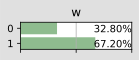

In [0]:
%matplotlib inline
gnb.showProba(ie.posterior(w))

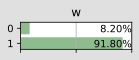

In [0]:
gnb.showPosterior(bn, {'s':1, 'c':0}, 'w')

## Inference in the whole Bayes Net

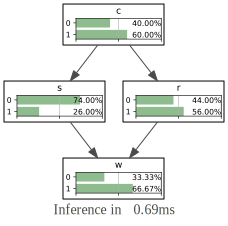

In [0]:
gnb.showInference(bn, evs={})

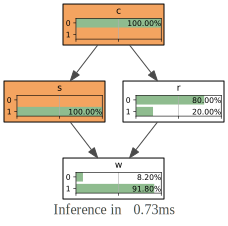

In [0]:
gnb.showInference(bn, evs={'s':1, 'c':0})

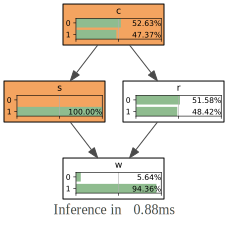

In [0]:
gnb.showInference(bn,evs={'s':1,'c':[0.3,0.9]})

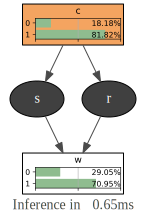

In [0]:
gnb.showInference(bn,evs={'c':[0.3,0.9]},targets={'c','w'})